# <center>Facebook Link prediction (Graph Data)

### Problem statement:
    Given a directed social graph, have to predict missing links to recommend users
### Business objectives and constraints:
    No low-latency requirement.
    Probability of prediction is useful to recommend highest probability links
### Performance metric for supervised learning:  
    Both precision and recall is important so F1 score is good choice
    Confusion matrix

In [111]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")

# most useful library for this case study
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

import random
import os
import csv
import pickle

In [2]:
#creating a csv file without header for reading it as a graph
if not os.path.isfile("train_woheader.csv"):
    traincsv = pd.read_csv("train.csv")
    traincsv.to_csv("train_woheader.csv",header=False,index=False)
    print("Done creating a csv without header")
else:
    g = nx.read_edgelist("train_woheader.csv",delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


> Displaying a sub graph

DiGraph with 66 nodes and 50 edges


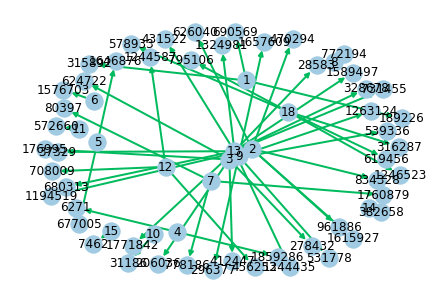

In [3]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv("train.csv",nrows=50).to_csv("train_woheader_sample.csv",header=False,index=False)

subgraph = nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos = nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color="#A0CBE2",edge_color='#00bb5e',width=2,edge_cmap=plt.cm.Blues,with_labels=True)
print(nx.info(subgraph))

# Exploratory data analysis

In [4]:
# number of unique persons
print("The number of unique users: ",len(g.nodes()))

The number of unique users:  1862220


### Number of followers for each person
    We can calculate this using the in-degree for each node/user

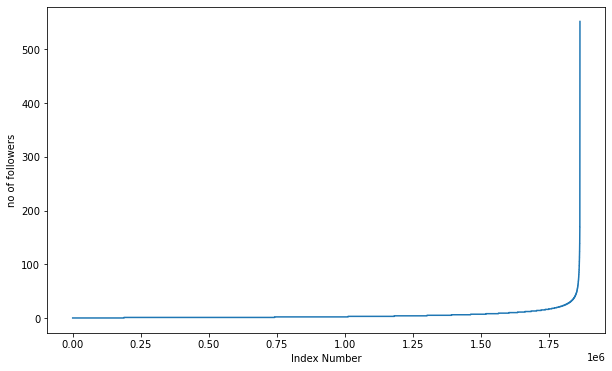

In [5]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel("Index Number")
plt.ylabel("no of followers")
plt.show()

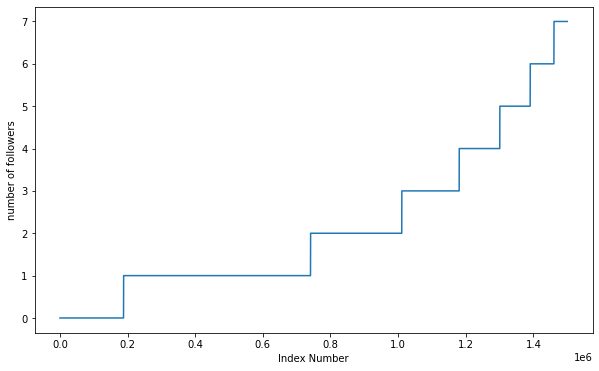

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index Number')
plt.ylabel('number of followers')
plt.show()

In [7]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [8]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


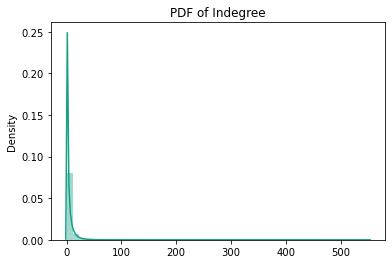

In [9]:
sns.distplot(indegree_dist, color = '#16A085')
plt.title('PDF of Indegree')
plt.show()

### Number of people each person is following
    we can calculate this using the out degree for each node/user

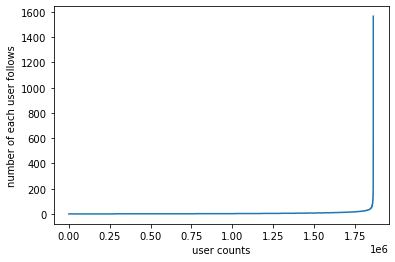

In [10]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.plot(outdegree_dist)
plt.xlabel("user counts")
plt.ylabel("number of each user follows")
plt.show()

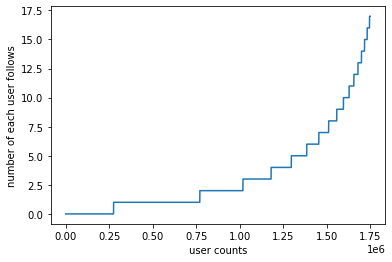

In [11]:
plt.plot(outdegree_dist[0:1750000])
plt.xlabel('user counts')
plt.ylabel('number of each user follows')
plt.show()

In [12]:
# 90-100 percentile
for i in range(1,11):
    print(90+i,"percentile value is",np.percentile(outdegree_dist,90+i))

91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [13]:
# 99-100 percentile values
for i in  range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


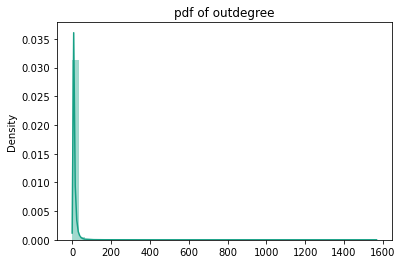

In [14]:
sns.distplot(outdegree_dist,color='#16A085')
plt.title('pdf of outdegree')
plt.show()

In [15]:
print('Number of users who do\'t follow anyone are ',sum(np.array(outdegree_dist)==0),'and its % is',
     (sum(np.array(outdegree_dist)==0)/len(outdegree_dist))*100)

Number of users who do't follow anyone are  274512 and its % is 14.741115442858524


In [16]:
print('Number of users who do\'t have any followers ',
     sum(np.array(indegree_dist)==0),'and its %',
    (sum(np.array(indegree_dist)==0)/len(indegree_dist))*100)

Number of users who do't have any followers  188043 and its % 10.097786512871734


In [17]:
# number of people who have 0 followers and following
count = 0
for i in g.nodes:
    if g.in_degree(i)==0 and g.out_degree(i)==0:
        count+=1
print("number of people who have 0 followers and not following anyone : ",count)

number of people who have 0 followers and not following anyone :  0


In [18]:
in_out_degree = []
for i in g.nodes():
    in_out_degree.append(g.in_degree(i)+g.out_degree(i))
in_out_degree.sort()
print('Min of no of followers + following is',min(in_out_degree))
print(sum(np.array(in_out_degree)==min(in_out_degree)),'persons have the min number of followers and following')

Min of no of followers + following is 1
334291 persons have the min number of followers and following


In [19]:
print('Max of no of followers + following is',max(in_out_degree))
print(sum(np.array(in_out_degree)==max(in_out_degree)),'persons have the max number of followers and following')

Max of no of followers + following is 1579
1 persons have the max number of followers and following


# Posing a problem as classification problem
    Greating link which does't exists between 2 nodes and such that the shotest path between them is greater than 2. So we can pose this as a supervised learning problem.

In [20]:
%%time 
if not os.path.isfile('missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 
                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

CPU times: total: 1.02 s
Wall time: 2.31 s


In [21]:
len(missing_edges)

9437519

# Train and test split

In [22]:
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile("test_pos_after_eda.csv")):
    df_pos = pd.read_csv('train.csv')
    df_neg = pd.DataFrame(list(missing_edges),columns=['source_node','destination_node'])
    print("number of nodes with edges",df_pos.shape[0])
    print("number of nodes without edges",df_neg.shape[0])
    
    x_train_pos, x_test_pos, y_train_pos, y_test_pos = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2,random_state=42)
    x_train_neg, x_test_neg, y_train_neg, y_test_neg = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2,random_state=42)
    
    x_train_pos.to_csv('train_pos_after_eda.csv',header=False,index=False)
    x_test_pos.to_csv('test_pos_after_eda.csv',header=False,index=False)
    x_train_neg.to_csv('train_neg_after_eda.csv',header=False,index=False)
    x_test_neg.to_csv('test_neg_after_eda.csv',header=False,index=False)
else:
    del missing_edges

number of nodes with edges 9437519
number of nodes without edges 9437519


In [23]:
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):
    train_graph = nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph = nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    
    print(nx.info(train_graph))
    print(nx.info(test_graph))
    
    #finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes)
    test_nodes_pos = set(test_graph.nodes)
    
    trYES_teYES = len(train_nodes_pos.intersection(test_nodes_pos))
    trYES_teNO = len(train_nodes_pos - test_nodes_pos)
    trNO_teYes = len(test_nodes_pos-train_nodes_pos)
    
    print("number of user in both train and test ",trYES_teYES)
    print("number of user in train but not in test",trYES_teNO)
    print("number of user in test but not in train",trNO_teYes,"and its % is",(trNO_teYes/len(test_nodes_pos))*100)

DiGraph with 1780564 nodes and 7550015 edges
DiGraph with 1145880 nodes and 1887504 edges
number of user in both train and test  1064224
number of user in train but not in test 716340
number of user in test but not in train 81656 and its % is 7.1260515935351005


In [24]:
# final train and test data sets
if (not os.path.isfile('train_after_eda.csv')) and (not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and (not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and (os.path.isfile('test_neg_after_eda.csv')):
    
    x_train_pos= pd.read_csv('train_pos_after_eda.csv',names = ['source_node','destination_node'])
    x_test_pos= pd.read_csv('test_pos_after_eda.csv',names = ['source_node','destination_node'])
    x_train_neg= pd.read_csv('train_neg_after_eda.csv',names = ['source_node','destination_node'])
    x_test_neg= pd.read_csv('test_neg_after_eda.csv',names = ['source_node','destination_node'])
    
    x_train = x_train_pos.append(x_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    x_test = x_test_pos.append(x_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg))
    
    x_train.to_csv('data/train_after_eda.csv',header=False,index=False)
    x_test.to_csv('data/test_after_eda.csv',header=False,index=False)
    
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

In [25]:
print("Data points in train data",x_train.shape)
print("Data points in test data",x_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


# Featurizing the data

In [26]:
nx.info(train_graph)

'DiGraph with 1780564 nodes and 7550015 edges'

### 1) Jaccard Index
    concept from set theory to find the set simmilarity

In [27]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a)))==0 | len(set(train_graph.successors(b)))==0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim           

In [28]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a)))==0 | len(set(train_graph.predecessors(b)))==0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                (len(set(train_graph.predecessors(a)).union(train_graph.predecessors(b))))
        return sim
    except:
        return 0

### 2) Shortest path

In [29]:
def shortpath(a,b):
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove(a,b)
            p = nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p = nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

### 3) Weakly connected components(check for same community)

In [30]:
wcc = list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
        for i in wcc:
            if a in i:
                index = i
                break
        if (b in index):
            train_graph.remove_edge(a,b)
            if shortpath(a,b)==-1:
                train_graph.add_edge(a,b)
                return 0
            else:
                train_graph.add_edge(a,b)
                return 1
        else:
            return 0
    else:
        for i in wcc:
            if a in i:
                index=i
                break
        if (b in index):
            return 1
        else:
            return 0

### 4) Adamic/Adar Index

In [31]:
def adarindex(a,b):
    sumval=0
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sumval = sumval+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sumval
        else:
            return 0
    except:
        return 0

### 5) Was person following back

In [32]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

### 6) Katz Centrality
similary to google's pagerank, in identifying the most useful website and rank it.

In [33]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)

In [34]:
print('min value for katz',katz[min(katz, key=katz.get)])
print('max value for katz',katz[max(katz, key=katz.get)])
print('mean value of katz',float(sum(katz.values())) / len(katz))

min value for katz 0.0007313844906521844
max value for katz 0.003417090622300047
mean value of katz 0.0007484129238002135


In [35]:
mean_katz = float(sum(katz.values()))/len(katz)
mean_katz

0.0007484129238002135

# Featurizing and reading the samples from train and test

In [36]:
#https://stackoverflow.com/a/22259008/4084039
if os.path.isfile('data/train_after_eda.csv'):
    n_train = sum(1 for line in open("data/train_after_eda.csv"))
    s = 100000
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [37]:
#https://stackoverflow.com/a/22259008/4084039
if os.path.isfile('data/test_after_eda.csv'):
    n_test = sum(1 for line in open("data/test_after_eda.csv"))
    s = 100000
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [38]:
df_train = pd.read_csv('data/train_after_eda.csv',skiprows=skip_train,names=['source_node','destination_node'])
df_train['indicator'] = pd.read_csv('data/train_y.csv',skiprows=skip_train)
print(df_train.shape)
df_train.head()

(100001, 3)


,source_node,destination_node,indicator
0,1075976,1506254,1.0
1,76671,361362,1.0
2,1453,816925,1.0
3,504535,203366,1.0
4,1512635,491483,1.0


In [39]:
df_test = pd.read_csv('data/test_after_eda.csv',skiprows=skip_test,names=['source_node','destination_node'])
df_test['indicator'] = pd.read_csv('data/test_y.csv',skiprows=skip_test)
print(df_test.shape)
df_test.head()

(100001, 3)


,source_node,destination_node,indicator
0,619970,573968,1.0
1,293743,53096,1.0
2,911842,449582,1.0
3,1845303,1545963,1.0
4,378639,1401283,1.0


## Basic Features extraction

In [40]:
df_train["source_followers"] = df_train.apply(lambda x: len(set(train_graph.predecessors(x['source_node']))) if x['source_node'] in train_graph.nodes else 0, axis=1)
df_train["source_followees"] = df_train.apply(lambda x: len(set(train_graph.successors(x['source_node']))) if x['source_node'] in train_graph.nodes else 0, axis=1)
df_train["destination_followers"] = df_train.apply(lambda x: len(set(train_graph.predecessors(x['destination_node']))) if x['destination_node'] in train_graph.nodes else 0, axis=1)
df_train["destination_followees"] = df_train.apply(lambda x: len(set(train_graph.successors(x['destination_node']))) if x['destination_node'] in train_graph.nodes else 0, axis=1)

In [41]:
df_train["followers_intersection"] = df_train.apply(lambda x: len(set(train_graph.predecessors(x['source_node'])).intersection(set(train_graph.predecessors(x['destination_node'])))) if (x['source_node'] in train_graph.nodes) and (x['destination_node'] in train_graph.nodes) else 0, axis=1)
df_train["followees_intersection"] = df_train.apply(lambda x: len(set(train_graph.successors(x['source_node'])).intersection(set(train_graph.successors(x['destination_node'])))) if (x['source_node'] in train_graph.nodes) and (x['destination_node'] in train_graph.nodes) else 0, axis=1)

In [42]:
df_train.head()

,source_node,destination_node,indicator,source_followers,source_followees,destination_followers,destination_followees,followers_intersection,followees_intersection
0,1075976,1506254,1.0,67,49,323,55,44,5
1,76671,361362,1.0,3,8,3,4,2,3
2,1453,816925,1.0,8,23,2,0,0,0
3,504535,203366,1.0,1,1,2,2,0,0
4,1512635,491483,1.0,20,20,7,15,1,1


## Adding the features formulated before

In [43]:
df_train['jaccard_followees'] = df_train.apply(lambda x: jaccard_for_followees(x['source_node'],x['destination_node']),axis=1)
df_train['jaccard_followers'] = df_train.apply(lambda x: jaccard_for_followers(x['source_node'],x['destination_node']),axis=1)

In [44]:
df_train['shotest_path'] = df_train.apply(lambda x: shortpath(x['source_node'],x['destination_node']),axis=1)

In [45]:
df_train['same_wcc'] = df_train.apply(lambda x: belongs_to_same_wcc(x['source_node'],x['destination_node']),axis=1)

In [46]:
df_train['adarindex'] = df_train.apply(lambda x: adarindex(x['source_node'],x['destination_node']),axis=1)

In [47]:
df_train['follows_back'] = df_train.apply(lambda x: follows_back(x['source_node'],x['destination_node']),axis=1)

In [48]:
df_train['same_wcc'] = df_train.apply(lambda x: belongs_to_same_wcc(x['source_node'],x['destination_node']),axis=1)

### Weighted features
\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

    1) incoming edges
    2) outgoing edges
    3) incoming + outgoing
    4) incoming * outgoing

In [55]:
df_train['incoming_weight_s'] = df_train.apply(lambda x: (1.0/(np.sqrt(1+len(set(train_graph.predecessors(x['source_node'])))))) if x['source_node'] in train_graph.nodes else 1 ,axis=1)
df_train['incoming_weight_d'] = df_train.apply(lambda x: 1.0/(np.sqrt(1+len(set(train_graph.predecessors(x['destination_node']))))) if x['destination_node'] in train_graph.nodes else 1,axis=1 )

df_train['outgoing_weight_s'] = df_train.apply(lambda x: 1.0/(np.sqrt(1+len(set(train_graph.successors(x['source_node']))))) if x['source_node'] in train_graph.nodes else 1,axis=1 )
df_train['outgoing_weight_d'] = df_train.apply(lambda x: 1.0/(np.sqrt(1+len(set(train_graph.successors(x['destination_node']))))) if x['destination_node'] in train_graph.nodes else 1,axis=1 )

In [61]:
df_train['in_plus_out_s'] = df_train['incoming_weight_s'] + df_train['outgoing_weight_s']
df_train['in_plus_out_d'] = df_train['incoming_weight_d'] + df_train['outgoing_weight_d']
df_train['in_mul_out_s'] = df_train['incoming_weight_s'] * df_train['outgoing_weight_s']
df_train['in_mul_out_d'] = df_train['incoming_weight_d'] * df_train['outgoing_weight_d']

In [62]:
df_train.head()

,source_node,destination_node,indicator,source_followers,source_followees,destination_followers,destination_followees,followers_intersection,followees_intersection,jaccard_followees,...,adarindex,follows_back,incoming_weight_s,incoming_weight_d,outgoing_weight_s,outgoing_weight_d,in_plus_out_s,in_plus_out_d,in_mul_out_s,in_mul_out_d
0,1075976,1506254,1.0,67,49,323,55,44,5,0.050505,...,2.018365,0,0.121268,0.055556,0.141421,0.133631,0.262689,0.189186,0.017150,0.007424
1,76671,361362,1.0,3,8,3,4,2,3,0.333333,...,3.821606,0,0.500000,0.500000,0.333333,0.447214,0.833333,0.947214,0.166667,0.223607
2,1453,816925,1.0,8,23,2,0,0,0,0.000000,...,0.000000,0,0.333333,0.577350,0.204124,1.000000,0.537457,1.577350,0.068041,0.577350
3,504535,203366,1.0,1,1,2,2,0,0,0.000000,...,0.000000,1,0.707107,0.577350,0.707107,0.577350,1.414214,1.154701,0.500000,0.333333
4,1512635,491483,1.0,20,20,7,15,1,1,0.029412,...,0.491781,0,0.218218,0.353553,0.218218,0.250000,0.436436,0.603553,0.047619,0.088388


#### Lets see how important these derived features are by doing univariate analysis on some of these features

(1.0, 500.0)

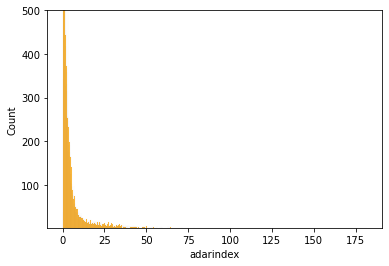

In [105]:
fig, ax = plt.subplots()
sns.histplot(df_train[df_train['indicator']==1.0]['adarindex'],color='orange')
sns.histplot(df_train[df_train['indicator']==0.0]['adarindex'],color='black')
ax.set_ylim(1,500)

(1.0, 1000.0)

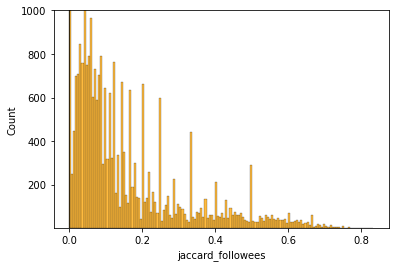

In [98]:
fig, ax = plt.subplots()
sns.histplot(df_train[df_train['indicator']==1.0]['jaccard_followees'],color='orange')
sns.histplot(df_train[df_train['indicator']==0.0]['jaccard_followees'],color='black')
ax.set_ylim(1,1000)

<AxesSubplot:xlabel='in_plus_out_s', ylabel='Density'>

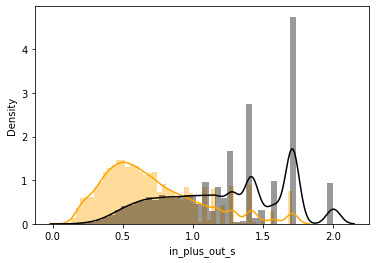

In [88]:
sns.distplot(df_train[df_train['indicator']==1.0]['in_plus_out_s'],color='orange')
sns.distplot(df_train[df_train['indicator']==0.0]['in_plus_out_s'],color='black')

<AxesSubplot:xlabel='in_mul_out_s', ylabel='Density'>

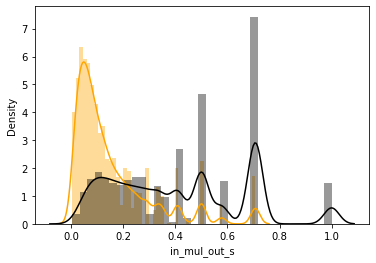

In [75]:
sns.distplot(df_train[df_train['indicator']==1.0]['in_mul_out_s'],color='orange')
sns.distplot(df_train[df_train['indicator']==0.0]['in_mul_out_s'],color='black')

### <center>Here we can conclude that most of the features derived are helpful in predicting the link, we can further use PCA or TSNE for verifing the combined impact of all the features in predicting the link

# <center>Lets build models on top of these features derived

In [117]:
df_train = df_train.dropna()

In [118]:
x = df_train.drop(['indicator','source_node','destination_node'],axis=1)
y = df_train['indicator']

x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size=0.2,random_state=42)

print("The shape of x train dataset          ",x_train.shape)
print("The shape of x cross validate dataset ",x_cv.shape)
print("The shape of y train dataset          ",y_train.shape)
print("The shape of y cross validate dataset ",y_cv.shape)

The shape of x train dataset           (80000, 20)
The shape of x cross validate dataset  (20000, 20)
The shape of y train dataset           (80000,)
The shape of y cross validate dataset  (20000,)


## 1) LogisticRegression

In [122]:
alpha = [10**x for x in range(-5,6)]
acc_C = []

for i in alpha:
    clf = LogisticRegression(C=i,n_jobs=5)
    clf.fit(x_train,y_train)
    cv_pred = clf.predict(x_cv)
    acc_C.append(accuracy_score(y_cv, cv_pred))
    print("Accuracy score when C is",i,"-->",accuracy_score(y_cv, cv_pred))

Accuracy score when C is 1e-05 --> 0.87615
Accuracy score when C is 0.0001 --> 0.919
Accuracy score when C is 0.001 --> 0.9457
Accuracy score when C is 0.01 --> 0.9575
Accuracy score when C is 0.1 --> 0.9639
Accuracy score when C is 1 --> 0.9658
Accuracy score when C is 10 --> 0.96575
Accuracy score when C is 100 --> 0.9657
Accuracy score when C is 1000 --> 0.96545
Accuracy score when C is 10000 --> 0.96565
Accuracy score when C is 100000 --> 0.9656


the optimal value for C(alpha) is  1 with accuracy score 0.9658


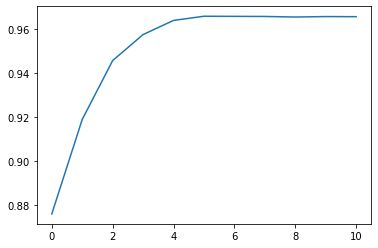

In [130]:
print('the optimal value for C(alpha) is ',alpha[acc_C.index(max(acc_C))],"with accuracy score",max(acc_C))
plt.plot(acc_C)
plt.show()

#### By traing the Logistic Regression with alpha of 1 we are able to get accuracy of about 96%

## 2) DecisionTreeClassifier

In [135]:
depth = [x for x in range(3,15)]
acc_depth = []

for i in depth:
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(x_train,y_train)
    dt_pred = dt.predict(x_cv)
    print("The accuracy when max depth is",i,"-->",accuracy_score(y_cv,dt_pred))
    acc_depth.append(accuracy_score(y_cv,dt_pred))

The accuracy when max depth is 3 --> 0.88365
The accuracy when max depth is 4 --> 0.916
The accuracy when max depth is 5 --> 0.9498
The accuracy when max depth is 6 --> 0.9514
The accuracy when max depth is 7 --> 0.9627
The accuracy when max depth is 8 --> 0.96465
The accuracy when max depth is 9 --> 0.9701
The accuracy when max depth is 10 --> 0.9708
The accuracy when max depth is 11 --> 0.96985
The accuracy when max depth is 12 --> 0.9693
The accuracy when max depth is 13 --> 0.96905
The accuracy when max depth is 14 --> 0.9685


the optimal value for depth of DecisionTreeClassifier is  10 with accuracy score 0.9708


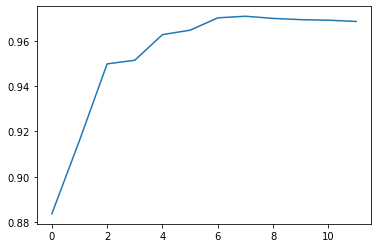

In [136]:
print('The optimal value for depth of DecisionTreeClassifier is ',depth[acc_depth.index(max(acc_depth))],"with accuracy score",max(acc_depth))
plt.plot(acc_depth)
plt.show()

#### By traing the DecisionTree Classifier with depth of 10 we are able to get accuracy of about 97%

In [142]:
baselearner = [x for x in range(100,1100,100)]
acc_rf = []

for i in baselearner:
    rf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    rf.fit(x_train,y_train)
    rf_pred = rf.predict(x_cv)
    print("The accuracy when number of baselearners is",i,"-->",accuracy_score(y_cv,rf_pred))
    acc_rf.append(accuracy_score(y_cv,rf_pred))

The accuracy when number of baselearners is 100 --> 0.9704
The accuracy when number of baselearners is 200 --> 0.9697
The accuracy when number of baselearners is 300 --> 0.96955
The accuracy when number of baselearners is 400 --> 0.96935
The accuracy when number of baselearners is 500 --> 0.9696
The accuracy when number of baselearners is 600 --> 0.9693
The accuracy when number of baselearners is 700 --> 0.9698
The accuracy when number of baselearners is 800 --> 0.96975
The accuracy when number of baselearners is 900 --> 0.9698
The accuracy when number of baselearners is 1000 --> 0.9699


The optimal value for depth of DecisionTreeClassifier is  100 with accuracy score 0.9704


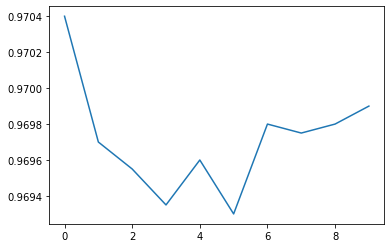

In [143]:
print('The optimal value for depth of DecisionTreeClassifier is ',baselearner[acc_rf.index(max(acc_rf))],"with accuracy score",max(acc_rf))
plt.plot(acc_rf)
plt.show()

#### Here i have skipped training the algorithums using the optimal value, and doing performing the test validation on the test dataset. 
#### The objective of the case study was to learn how to form a graph based data as supervised learning dataset, and to learn various featurizations we can incorporate for graph based data.